In [47]:
# import dependencies
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

Sagi's version of import and fill in missing years:

In [48]:
#names_df = pd.read_csv("Resources/yob1978.txt", delimiter =",", names=["Name", "Gender", "YearOfBirth"],dtype={"Name":"str","Gender":"str", "YearOfBirth":np.int32})

start_year=1880
end_year=2019
yearlist= list(range(start_year,end_year,1))
#print(yearlist)
year_df=pd.DataFrame(yearlist)
year_df["dummy_col"]=1
year_df.set_index("dummy_col", inplace=True)
filename_list=[]
for file in os.listdir("names"):
    if file.endswith(".txt") and int(file[3:7]) >= start_year:
        df =  pd.read_csv("names/"+file, delimiter =",", names=["Name", "Gender", "CountOfNames"],dtype={"Name":"str","Gender":"str", "CountOfNames":np.int32})
        df["Year"] = int(file[3:7])
        
        df = df[["Year", "Name", "Gender", "CountOfNames"]]
        filename_list.append(df)
        
names_df = pd.concat(filename_list, axis=0, ignore_index=True)
names_df.sort_values(by=["Name","Gender","Year"], inplace=True)
unique_names_list = names_df.drop_duplicates(subset=["Name", "Gender"])[["Name", "Gender"]]
unique_names_list["dummy_col"]=1
unique_names_list.set_index("dummy_col", inplace=True)

final_data_set = unique_names_list.join(year_df,on="dummy_col",how = "outer")
final_data_set.rename(columns={0:"Year"}, inplace=True)

In [49]:
### We have a dataset with entries for all names for all years of analysis. 
### We need to now update the counts of each row with the actual values.

data_set_with_counts = final_data_set.merge(names_df, on=["Name", "Gender", "Year"], how = "outer")
data_set_with_counts.fillna(0, inplace = True)
data_set_with_counts["Percent_Change"] = data_set_with_counts["CountOfNames"].pct_change() * 100

Create data frames of big percent change "spikes" and big negative percent change "spikes". Filter based on count of names and percent change. 

Don't include the year 1880; it's the "baseline" year.

In [50]:
big_spikes_df = data_set_with_counts.loc[(data_set_with_counts["CountOfNames"]>500) 
                         & (data_set_with_counts["Percent_Change"]>150) 
                         & (data_set_with_counts["Year"]>1880) 
                         & (data_set_with_counts["Percent_Change"]!=float('inf'))]

# big_spikes_df.to_csv('big_spikes.csv')

In [51]:
big_neg_spikes_df = data_set_with_counts.loc[(data_set_with_counts["CountOfNames"]>500) 
                         & (data_set_with_counts["Percent_Change"]<-50) 
                         & (data_set_with_counts["Year"]>1880) 
                         & (data_set_with_counts["Percent_Change"]!=float('inf'))]

# big_neg_spikes_df.to_csv('big_neg_spikes.csv')

Create the plot function. Add a path argument to move plots to the proper output folder.

In [52]:
def getPlot3(name,gender,center):
    
    fig, (ax1,ax2) = plt.subplots(nrows = 2,figsize = (15,10),gridspec_kw={'hspace':0.4})
    fig.suptitle(f'"{name}" ({gender}), {center}')

    # ax1 data
    plot1_df = data_set_with_counts.loc[(data_set_with_counts['Name']==name) & (data_set_with_counts['Gender']==gender)]
    
    # ax2 data
    plot2_df = data_set_with_counts.loc[(data_set_with_counts['Year']==center) & (data_set_with_counts['Gender']==gender)]
    plot2_point = data_set_with_counts.loc[(data_set_with_counts['Year']==center) & (data_set_with_counts['Gender']==gender) & (data_set_with_counts['Name']==name)]
     
    # set ax1 x-axis and values to plot
    x_axis1 = plot1_df['Year']
    values1 = plot1_df['CountOfNames']

    # set ax2 x-axis and values to plot    
    x_axis2 = plot2_df['CountOfNames']
    values2 = plot2_df['Percent_Change']    
    x_focus = plot2_point['CountOfNames']
    value_focus = plot2_point['Percent_Change']
    
    # plots
    ax1.plot(x_axis1,values1,color = 'coral',marker = 'o')
    ax2.scatter(x_axis2,values2,color = 'coral',marker = 'o')
    ax2.scatter(x_focus,value_focus, color = 'blue',marker = 's')
    
    # other elements
    ax1.vlines(center,0,max(values1)*1.05, color = 'blue')
    ax1.set_ylim(0,max(values1)*1.05)
    ax1.set_xlim(center-30,center+30)
    ax1.set_xticks(np.arange(center-30,center+30,10))
    ax1.set_title(f'Popularity of "{name}" ({gender})')
    ax1.set_ylabel('Count')
    ax1.set_xlabel('Year')
    ax1.grid()
    
    ax2.set_title(f'Popularity of "{name}" ({gender}) in {center}')
    ax2.set_ylabel('Pct Change from Prior Year')
    ax2.set_xlabel('Count')
    ax2.set_xlim(0,20000)
    ax2.grid()
    
    # uncomment this to save plots. Need to adjust path adjust path.
    # plt.savefig(f'neg_spike_plots/{name}-{gender}-{center}.png', dpi=300)
    

Iterate through the big_neg_spikes data frame to produce graphs. Be careful about the size of the data frame. 200 graphs takes a while.
Will throw an error if the output folder doesn't exist.

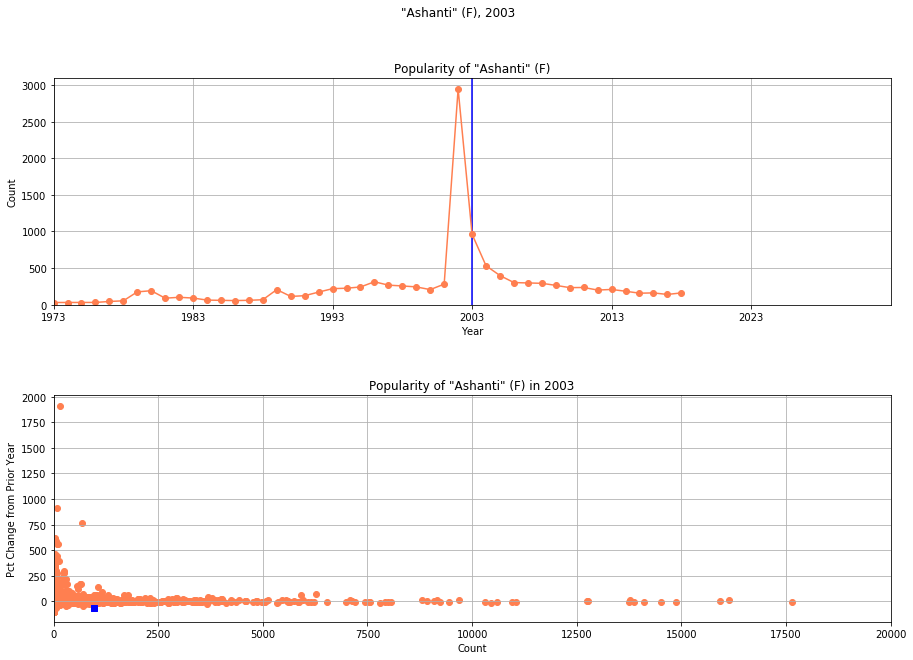

In [53]:
for x in big_neg_spikes_df.iterrows():
    getPlot3(x[1][0],x[1][1],x[1][2])
    break #remove this to make lots of plots
# this takes a long time, a few seconds per plot

This was just to research plots form individual names.

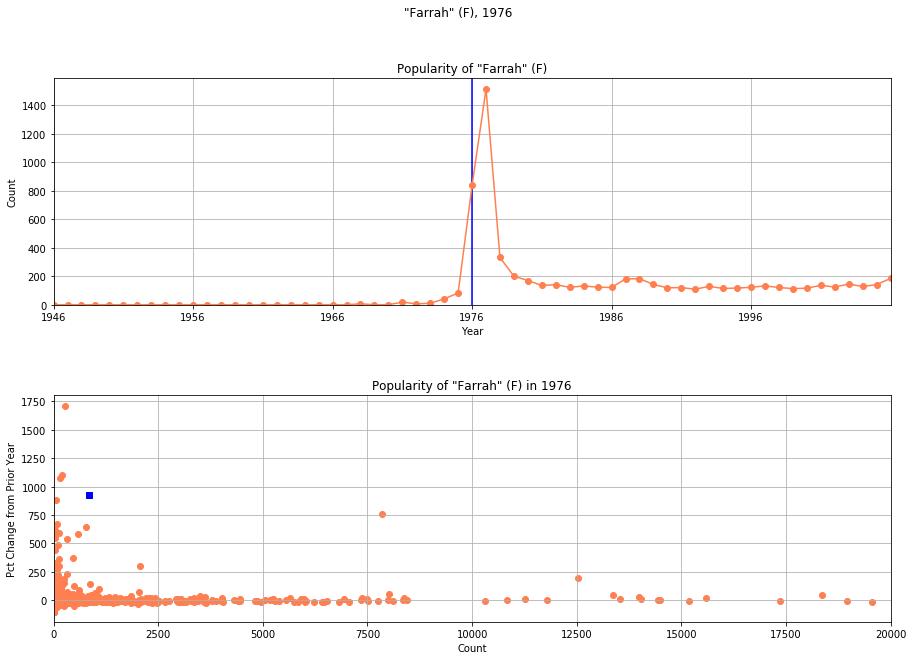

In [54]:
# look at a single name
name = {'name':'Farrah','gender':'F','center':1976}
getPlot3(name['name'],name['gender'],name['center'])

Import movie data and merge with name data. Create a data frame through which to iterate w/the plot function.
Should we clean the data frame up? Remove duplicate columns?

In [55]:
movies_df = pd.read_csv('MovieData/Resources/NameTable.csv')
movies_df['YearAfter'] = movies_df['Year'] + 1


movies_merged_df = pd.merge(movies_df, data_set_with_counts,  how='inner', left_on=['Name','YearAfter'], right_on = ['Name','Year'])

filter_df = movies_merged_df.loc[(movies_merged_df['CountOfNames']>100) 
                          & (movies_merged_df['Percent_Change']>80.00)]
sorted_df = filter_df.sort_values('Percent_Change',ascending = False)

# uncomment to save a csv. adjust path.
#sorted_df.to_csv('movie_spikes.csv')

In [56]:
movies_describe_df = movies_merged_df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
movies_describe_df.head()

,Name,Year_x,Movie,YearAfter,Gender,Year_y,CountOfNames,Percent_Change
0,Henry,1915,The Birth of a Nation,1916,F,1916,82.0,13.888889
1,Henry,1915,The Birth of a Nation,1916,M,1916,10656.0,5.109489
2,Lillian,1915,The Birth of a Nation,1916,F,1916,9592.0,0.481877
3,Lillian,1915,The Birth of a Nation,1916,M,1916,26.0,8.333333
4,Mae,1915,The Birth of a Nation,1916,F,1916,2607.0,4.867257


In [57]:
movies_describe_df['Percent_Change'].describe()

count    1195.000000
mean        5.664104
std        51.436886
min      -100.000000
25%        -9.512046
50%        -1.445783
75%        10.062305
max       778.431373
Name: Percent_Change, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x1e90218d4e0>,
 'caps': [<matplotlib.lines.Line2D at 0x1e904afa550>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e90218d470>],
 'medians': [<matplotlib.lines.Line2D at 0x1e904afaba8>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e904afa780>],
 'means': []}

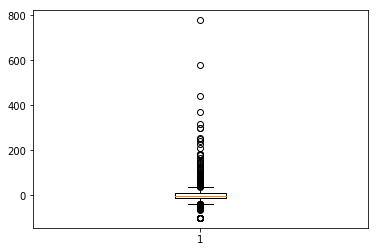

In [58]:
plt.boxplot(movies_describe_df['Percent_Change'])

(array([0.00000000e+00, 5.15021459e-04, 9.44206009e-04, 2.48927039e-03,
        2.06008584e-03, 7.89699571e-03, 2.21459227e-02, 3.03004292e-02,
        1.39914163e-02, 5.06437768e-03, 3.43347639e-03, 2.48927039e-03,
        1.88841202e-03, 1.28755365e-03, 6.00858369e-04, 6.00858369e-04,
        8.58369099e-04, 7.72532189e-04, 2.57510730e-04, 3.43347639e-04,
        8.58369099e-05, 1.71673820e-04, 2.57510730e-04, 8.58369099e-05,
        8.58369099e-05, 2.57510730e-04, 8.58369099e-05, 0.00000000e+00,
        8.58369099e-05, 0.00000000e+00, 8.58369099e-05, 8.58369099e-05,
        1.71673820e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.71673820e-04, 0.00000000e+00, 8.58369099e-05,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        8.58369099e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.58369099e-05,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

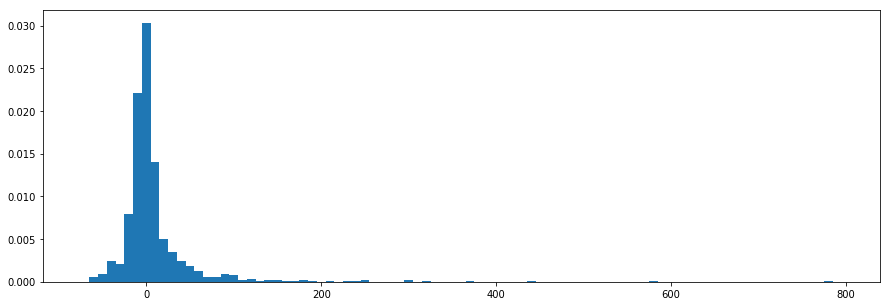

In [59]:
movie_data = movies_describe_df['Percent_Change'].sort_values()
plt.figure(figsize=(15,5))
# plt.hist(data, bins=np.arange(data.min(), data.max(),5))
plt.hist(movie_data, bins=np.arange(-75, 800,10),density=True)

Get plots from the movie data frame.

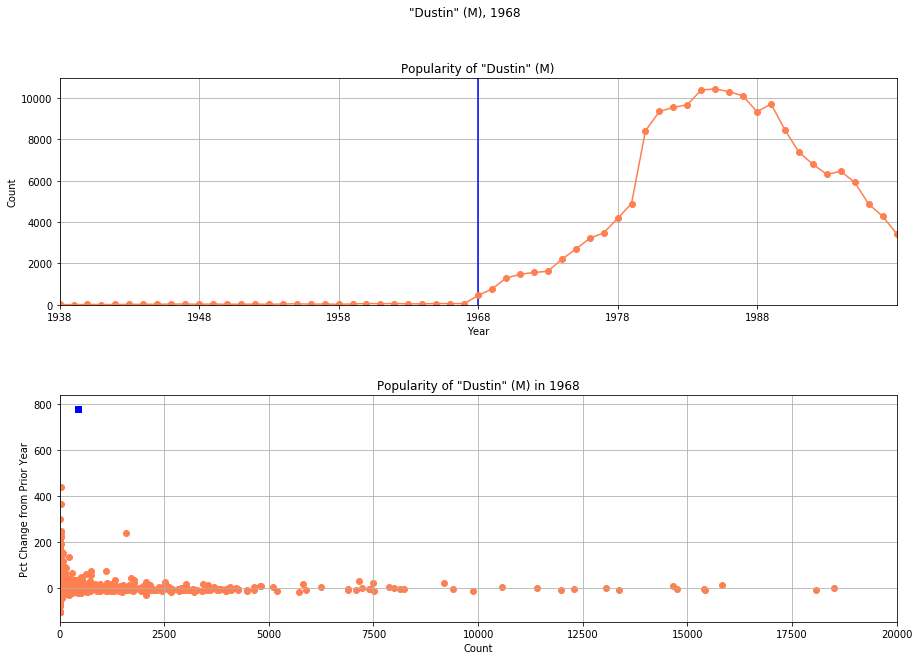

In [60]:
for x in sorted_df.iterrows():
    getPlot3(x[1][0],x[1][4],x[1][3])
    break # remove this to iterate through entire dataframe

Import billboard data and merge with name data. Create a data frame through which to iterate w/the plot function. Should we clean the data frame up? Remove duplicate columns?

In [61]:
artists_df = pd.read_csv('summary_df_update.csv')
artists_df['YearAfter'] = artists_df['Date'].str[0:4].astype('int') + 1

songs_merged_df = pd.merge(artists_df, data_set_with_counts,  how='inner', left_on=['First Name','YearAfter'], right_on = ['Name','Year'])

filter_df = songs_merged_df.loc[(songs_merged_df['CountOfNames']>100) 
                          & (songs_merged_df['Percent_Change']>50.00)]
sorted_df = filter_df.sort_values('Percent_Change',ascending = False)

#uncomment to save a csv. adjust path.
# sorted_df.to_csv('Hot100_spikes.csv')

In [62]:
songs_describe_df = songs_merged_df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
songs_describe_df.head()

,Title,First Name,Date,YearAfter,Name,Gender,Year,CountOfNames,Percent_Change
1,Perfect,Ed,2017-12-30,2018,Ed,M,2018,11.0,57.142857
3,Shape Of You,Ed,2017-04-22,2018,Ed,M,2018,11.0,57.142857
5,Look What You Made Me Do,Taylor,2017-09-23,2018,Taylor,F,2018,2478.0,-8.188218
6,Look What You Made Me Do,Taylor,2017-09-23,2018,Taylor,M,2018,532.0,-7.155323
7,Despacito,Luis,2017-09-02,2018,Luis,F,2018,0.0,-100.000000


In [63]:
songs_describe_df['Percent_Change'].describe()

count    1013.000000
mean       -3.049979
std        39.904750
min      -100.000000
25%       -13.800553
50%        -4.565217
75%         5.053563
max       370.716228
Name: Percent_Change, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x1e97bfb7860>,
 'caps': [<matplotlib.lines.Line2D at 0x1e97bfb7208>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e97bfb76d8>],
 'medians': [<matplotlib.lines.Line2D at 0x1e97a259710>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e97a259be0>],
 'means': []}

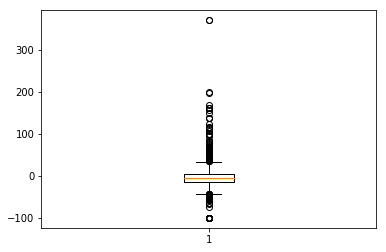

In [64]:
plt.boxplot(songs_describe_df['Percent_Change'])

(array([0.00020683, 0.00062048, 0.00217166, 0.00227508, 0.00465357,
        0.01013444, 0.02616339, 0.02730093, 0.00879007, 0.00517063,
        0.00289555, 0.00299897, 0.00175801, 0.00113754, 0.0008273 ,
        0.00041365, 0.00031024, 0.00020683, 0.00031024, 0.00031024,
        0.        , 0.00031024, 0.00010341, 0.00041365, 0.00010341,
        0.        , 0.        , 0.00020683, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00020683,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

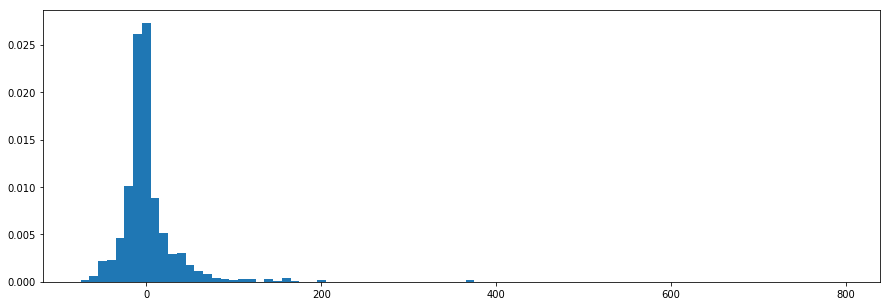

In [65]:
song_data = songs_describe_df['Percent_Change'].sort_values()
plt.figure(figsize=(15,5))
# plt.hist(data, bins=np.arange(data.min(), data.max(),5))
plt.hist(song_data, bins=np.arange(-75,800,10),density=True)

Get plots from the billboard data frame.

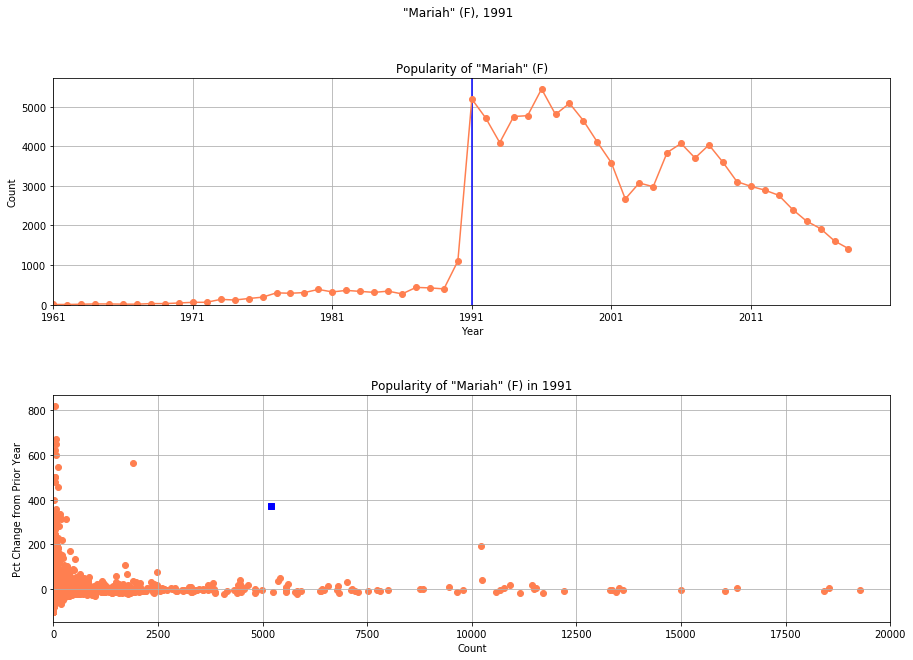

In [66]:
for x in sorted_df.iterrows():
    getPlot3(x[1][4],x[1][5],x[1][6])
    break # remove to iterate through data frame

Get manually researched data from spreadsheet.

In [67]:
df = pd.read_excel('big_spikes.xlsx')
df['Category'].unique()

array(['music', 'tv', 'movie', 'other', 'unknown'], dtype=object)

Get data to plot the grouped bar graph.

In [68]:
music=[]
tv=[]
movie=[]
unknown=[]
other=[]

for dec in np.arange(1890,2020,10):
    music.append(df.loc[(df['Category']=='music') & (df['Decade'] == dec)]['Name'].count())
    tv.append(df.loc[(df['Category']=='tv') & (df['Decade'] == dec)]['Name'].count())
    movie.append(df.loc[(df['Category']=='movie') & (df['Decade'] == dec)]['Name'].count())
    other.append(df.loc[(df['Category']=='other') & (df['Decade'] == dec)]['Name'].count())
    unknown.append(df.loc[(df['Category']=='unknown') & (df['Decade'] == dec)]['Name'].count())

Plot the grouped bar chart. If there were more time, I'd make this better.

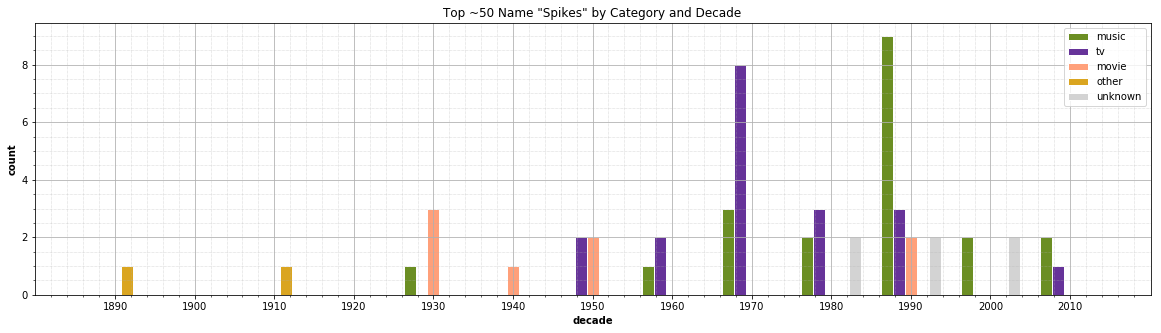

In [92]:
# set width of bar
plt.figure(figsize=[20,5])

barWidth = .15

# Set position of bar on X axis
r1 = np.arange(len(music))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]

# Make the plot
plt.bar(r1, music, facecolor='olivedrab', width=barWidth, edgecolor='white', label='music')
plt.bar(r2, tv, facecolor='rebeccapurple', width=barWidth, edgecolor='white', label='tv')
plt.bar(r3, movie, facecolor='lightsalmon', width=barWidth, edgecolor='white', label='movie')
plt.bar(r4, other, facecolor='goldenrod', width=barWidth, edgecolor='white', label='other')
plt.bar(r5, unknown, facecolor='lightgray', width=barWidth, edgecolor='white', label='unknown')

# Add xticks on the middle of the group bars
plt.xlabel('decade', fontweight='bold')
plt.ylabel('count', fontweight='bold')
plt.title('Top ~50 Name "Spikes" by Category and Decade')
plt.minorticks_on()
plt.xticks(r3,np.arange(1890,2020,10))

# Create legend & Show graphic
plt.legend()
plt.grid(which = 'minor', linestyle = ':',linewidth = '0.5') # do something with this...
plt.grid(which = 'major', linestyle = '-')
# plt.savefig('top_50_by_category_decade.png', dpi=300)

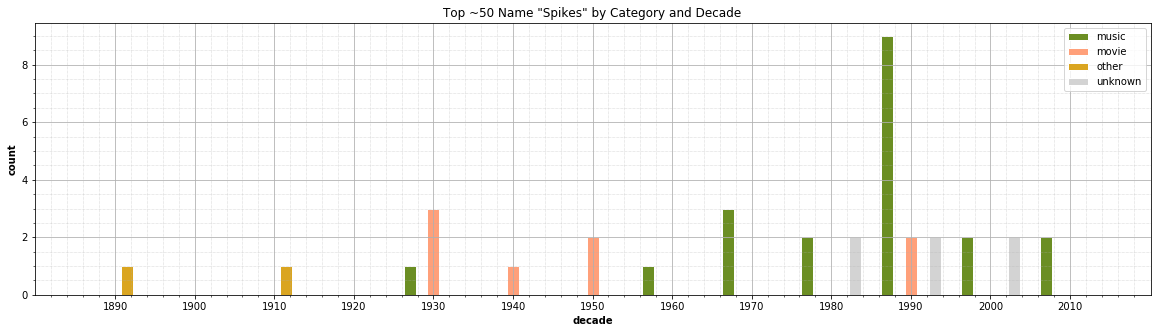

In [93]:
# hide TV for dramatic effect
# set width of bar
plt.figure(figsize=[20,5])

barWidth = .15

# Set position of bar on X axis
r1 = np.arange(len(music))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]

# Make the plot
plt.bar(r1, music, facecolor='olivedrab', width=barWidth, edgecolor='white', label='music')
plt.bar(r2, 0, facecolor='rebeccapurple', width=barWidth, edgecolor='white')
plt.bar(r3, movie, facecolor='lightsalmon', width=barWidth, edgecolor='white', label='movie')
plt.bar(r4, other, facecolor='goldenrod', width=barWidth, edgecolor='white', label='other')
plt.bar(r5, unknown, facecolor='lightgray', width=barWidth, edgecolor='white', label='unknown')

# Add xticks on the middle of the group bars
plt.xlabel('decade', fontweight='bold')
plt.ylabel('count', fontweight='bold')
plt.title('Top ~50 Name "Spikes" by Category and Decade')
plt.minorticks_on()
plt.xticks(r3,np.arange(1890,2020,10))

# Create legend & Show graphic
plt.legend()
plt.grid(which = 'minor', linestyle = ':',linewidth = '0.5') # do something with this...
plt.grid(which = 'major', linestyle = '-')
# plt.savefig('No_TV_top_50_by_category_decade.png', dpi=300)

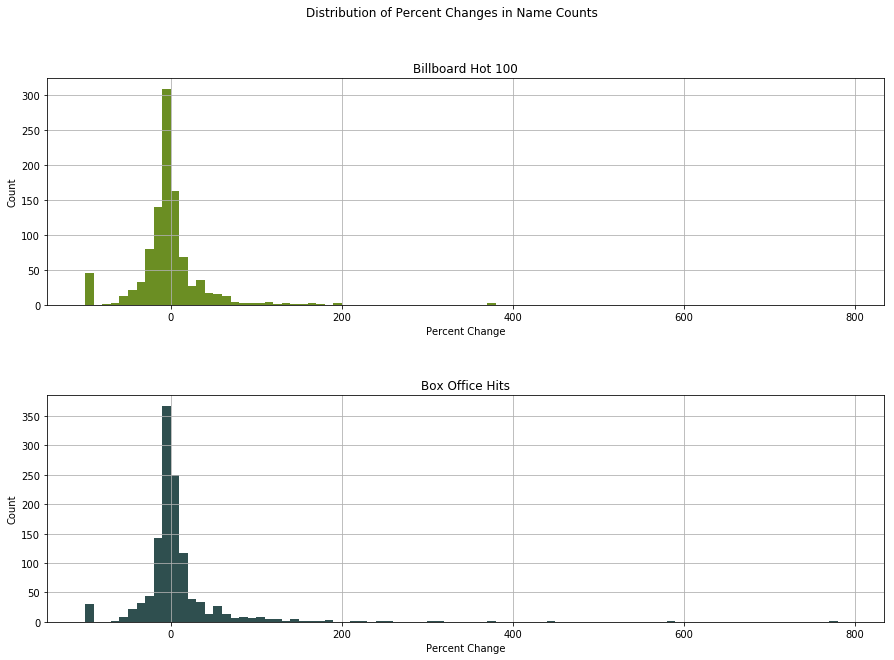

In [95]:
fig, (ax1,ax2) = plt.subplots(nrows = 2,figsize = (15,10),gridspec_kw={'hspace':0.4})
fig.suptitle('Distribution of Percent Changes in Name Counts')

movie_mu = movies_describe_df['Percent_Change'].mean()
movie_sigma = movies_describe_df['Percent_Change'].std()
movie_count = movies_describe_df['Percent_Change'].count()

song_mu = songs_describe_df['Percent_Change'].mean()
song_sigma = songs_describe_df['Percent_Change'].std()
song_count = movies_describe_df['Percent_Change'].count()

# plots
ax1.hist(song_data, bins=np.arange(-100,800,10),facecolor='olivedrab')
ax2.hist(movie_data, bins=np.arange(-100,800,10),facecolor='darkslategray')


# other elements
ax1.set_title('Billboard Hot 100')
ax1.set_ylabel('Count')
ax1.set_xlabel('Percent Change')
ax1.grid()

ax2.set_title('Box Office Hits')
ax2.set_ylabel('Count')
ax2.set_xlabel('Percent Change')
ax2.grid()
plt.savefig('compare_distributions.png', dpi=300)